# Librares

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import pydot
import kymatio
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from termcolor import colored
import matplotlib.pyplot as plt 
import plotly.graph_objects as go
import plotly.figure_factory as ff
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from kymatio import Scattering1D
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

c:\Users\Shuvashis\anaconda3\envs\Tempura\lib\site-packages\tqdm\auto.py:22: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [2]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Activation, Input, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
#import tensorflow_io as tfio

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [3]:
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.5)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))
tf.compat.v1.keras.backend.set_session(sess)

# CallBacks

In [4]:
epochs = 20

model_file_path = "best_model_file.hdf5"
checkpoint = ModelCheckpoint(model_file_path, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=5,  # <-- Corrected value
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001)

csv_logger = tf.keras.callbacks.CSVLogger('Model.log')

# Define a learning rate schedule
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate,
    decay_steps=10000,
    end_learning_rate=0.000001,
    power=0.5,
    cycle=False
)


callbacks = [earlystop, csv_logger, reduce_lr, checkpoint]

# Dataset

In [5]:
os.listdir(r'D:\MIET_HeartSound\Dataset\Dataset2\heart_sound')
data = os.path.join(r'D:\MIET_HeartSound\Dataset\Dataset2\heart_sound')
data

'D:\\MIET_HeartSound\\Dataset\\Dataset2\\heart_sound'

In [6]:
train_dir_path = os.path.join(data, 'train')
#valid_dir_path = os.path.join(data, 'val')

In [7]:
healthy = os.path.join(train_dir_path, 'healthy', 'a0007.wav')
unhealthy = os.path.join(train_dir_path, 'unhealthy', 'a0002.wav')

In [8]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    print(wav, sample_rate)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    print(wav, sample_rate)
    
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
#     wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

tf.Tensor(
[[0.04437256]
 [0.09277344]
 [0.08206177]
 ...
 [0.01379395]
 [0.01266479]
 [0.01278687]], shape=(71332, 1), dtype=float32) tf.Tensor(2000, shape=(), dtype=int32)
tf.Tensor([0.04437256 0.09277344 0.08206177 ... 0.01379395 0.01266479 0.01278687], shape=(71332,), dtype=float32) tf.Tensor(2000, shape=(), dtype=int64)
tf.Tensor(
[[ 0.00906372]
 [ 0.0222168 ]
 [ 0.02377319]
 ...
 [-0.0027771 ]
 [-0.00247192]
 [-0.00201416]], shape=(41657, 1), dtype=float32) tf.Tensor(2000, shape=(), dtype=int32)
tf.Tensor(
[ 0.00906372  0.0222168   0.02377319 ... -0.0027771  -0.00247192
 -0.00201416], shape=(41657,), dtype=float32) tf.Tensor(2000, shape=(), dtype=int64)


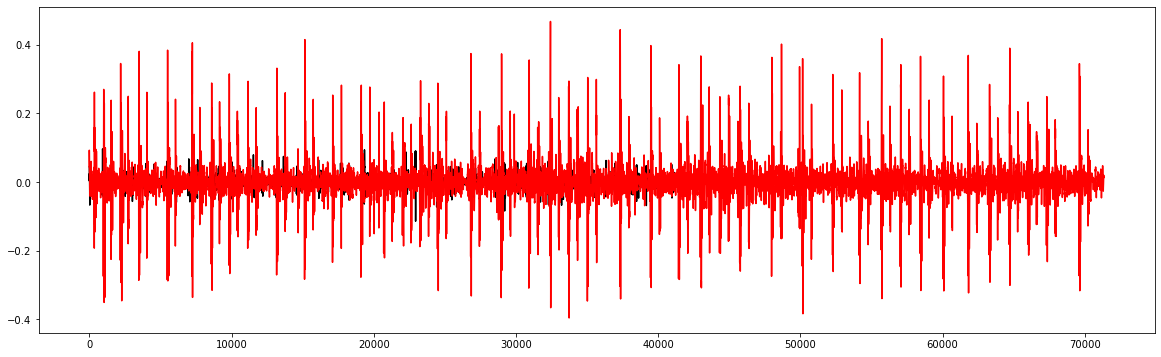

In [9]:
wave = load_wav_16k_mono(healthy)
nwave = load_wav_16k_mono(unhealthy)

plt.figure(figsize=(20, 6))
plt.plot(nwave, color='black')
plt.plot(wave, color='red')
plt.show()

In [10]:
healthy_heart_train = tf.data.Dataset.list_files(train_dir_path+'/healthy'+'/*.wav')
unhealthy_heart_train = tf.data.Dataset.list_files(train_dir_path+'/unhealthy'+'/*.wav')
#healthy_heart_valid = tf.data.Dataset.list_files(valid_dir_path+'/healthy'+'/*.wav')
#unhealthy_heart_valid = tf.data.Dataset.list_files(valid_dir_path+'/unhealthy'+'/*.wav')

In [11]:
hhl_train = tf.data.Dataset.zip((healthy_heart_train, tf.data.Dataset.from_tensor_slices(tf.ones(len(healthy_heart_train)))))
uhl_train = tf.data.Dataset.zip((unhealthy_heart_train, tf.data.Dataset.from_tensor_slices(tf.zeros(len(unhealthy_heart_train)))))
train_data = hhl_train.concatenate(uhl_train)

#hhl_valid = tf.data.Dataset.zip((healthy_heart_valid, tf.data.Dataset.from_tensor_slices(tf.ones(len(healthy_heart_valid)))))
#uhl_valid = tf.data.Dataset.zip((unhealthy_heart_valid, tf.data.Dataset.from_tensor_slices(tf.zeros(len(unhealthy_heart_valid)))))
#valid_data = hhl_valid.concatenate(uhl_valid)

In [12]:
#train_data = train_data.concatenate(valid_data)
lengths = []
for f in os.listdir(os.path.join(train_dir_path, 'healthy')):
    tensor_wave = load_wav_16k_mono(os.path.join(train_dir_path, 'healthy', f))
    lengths.append(len(tensor_wave))

tf.Tensor(
[[0.04437256]
 [0.09277344]
 [0.08206177]
 ...
 [0.01379395]
 [0.01266479]
 [0.01278687]], shape=(71332, 1), dtype=float32) tf.Tensor(2000, shape=(), dtype=int32)
tf.Tensor([0.04437256 0.09277344 0.08206177 ... 0.01379395 0.01266479 0.01278687], shape=(71332,), dtype=float32) tf.Tensor(2000, shape=(), dtype=int64)
tf.Tensor(
[[-0.00408936]
 [-0.00686646]
 [-0.00848389]
 ...
 [ 0.00643921]
 [ 0.00888062]
 [ 0.00592041]], shape=(71611, 1), dtype=float32) tf.Tensor(2000, shape=(), dtype=int32)
tf.Tensor(
[-0.00408936 -0.00686646 -0.00848389 ...  0.00643921  0.00888062
  0.00592041], shape=(71611,), dtype=float32) tf.Tensor(2000, shape=(), dtype=int64)
tf.Tensor(
[[-5.7983398e-04]
 [-1.3427734e-03]
 [-1.2207031e-03]
 ...
 [ 3.0517578e-05]
 [ 5.4931641e-04]
 [ 5.4931641e-04]], shape=(71193, 1), dtype=float32) tf.Tensor(2000, shape=(), dtype=int32)
tf.Tensor(
[-5.7983398e-04 -1.3427734e-03 -1.2207031e-03 ...  3.0517578e-05
  5.4931641e-04  5.4931641e-04], shape=(71193,), dtype=flo

In [13]:
# Calculate the lengths
train_length = tf.data.experimental.cardinality(train_data).numpy()
#valid_length = tf.data.experimental.cardinality(valid_data).numpy()

# Print the lengths
print("Length of train_data:", train_length)
#print("Length of valid_data:", valid_length)

Length of train_data: 3240


In [14]:
import librosa
J = 6
Q = 1
T = 30000
scatt = Scattering1D(J, T, Q)
def extract(file_path, label, wav_length=30000):
    def mfccs(wav):
        # Ensure wav is a numpy array
        wav = wav.numpy()
        
        mfcc = librosa.feature.mfcc(y=wav, sr=2000, n_mfcc=7)
        return mfcc

    
    
    def scattering_transform(wav):
        # Ensure wav is a numpy array
        wav = wav.numpy()
        
        meta = scatt.meta()
        order0 = np.where(meta['order'] == 0)
        order1 = np.where(meta['order'] == 1)
        order2 = np.where(meta['order'] == 2)

        Sx = scatt(wav) 
        return Sx[order1]
    
    wav = load_wav_16k_mono(file_path)
    wav = tf.cast(wav, dtype=tf.float32)  # Ensure wav is float32
    wav = wav / tf.reduce_max(tf.abs(wav))
    wav = wav[:wav_length] if tf.shape(wav)[0] > wav_length else tf.pad(wav, [(0, wav_length - tf.shape(wav)[0])], "CONSTANT")
    
    # Using tf.py_function to wrap the scattering transform
    mfcc = tf.py_function(mfccs, [wav], tf.float32)
    mfcc = tf.abs(mfcc)

    # Using tf.py_function to wrap the scattering transform
    scattering_transform = tf.py_function(scattering_transform, [wav], tf.float32)
    scattering_transform = tf.abs(scattering_transform)
    # You might need to set the shape of the output manually if required
    scattering_transform.set_shape((7, 469)) 
    
    concatenated_feature = tf.concat([scattering_transform, mfcc] , axis = 1)
    concatenated_feature = tf.expand_dims(concatenated_feature, axis = 2)
    
    return concatenated_feature, label

In [15]:
iterator = hhl_train.shuffle(buffer_size=10000).as_numpy_iterator()
iterator.next()
filepath, label = next(iterator)
print(filepath, label)

b'D:\\MIET_HeartSound\\Dataset\\Dataset2\\heart_sound\\train\\healthy\\a0108.wav' 1.0


In [16]:

feature, label = extract(filepath, label)
print(feature)


tf.Tensor(
[[-0.00030518]
 [-0.00073242]
 [-0.00042725]
 ...
 [ 0.00268555]
 [ 0.00314331]
 [ 0.003479  ]], shape=(64969, 1), dtype=float32) tf.Tensor(2000, shape=(), dtype=int32)
tf.Tensor(
[-0.00030518 -0.00073242 -0.00042725 ...  0.00268555  0.00314331
  0.003479  ], shape=(64969,), dtype=float32) tf.Tensor(2000, shape=(), dtype=int64)
tf.Tensor(
[[[1.3410321e-03]
  [1.4253550e-03]
  [1.5087818e-03]
  ...
  [2.0479280e+02]
  [1.8316270e+02]
  [1.9226680e+02]]

 [[2.6261960e-03]
  [2.8438352e-03]
  [3.0118353e-03]
  ...
  [1.1547057e+02]
  [1.1795065e+02]
  [1.0462189e+02]]

 [[5.6404062e-03]
  [6.1574597e-03]
  [6.5712510e-03]
  ...
  [5.8853699e+01]
  [5.9445435e+01]
  [5.2857834e+01]]

 ...

 [[4.7207605e-03]
  [5.4829596e-03]
  [6.3911644e-03]
  ...
  [3.6883659e+01]
  [3.3108597e+01]
  [2.6505032e+01]]

 [[1.3625020e-03]
  [1.6458542e-03]
  [2.0293267e-03]
  ...
  [2.6833149e+01]
  [2.3675545e+01]
  [2.3513144e+01]]

 [[5.4262998e-04]
  [5.6563749e-04]
  [5.9567794e-04]
  ...
  

In [17]:
train_data = train_data.map(extract)
train_data = train_data.cache()
train_data = train_data.shuffle(buffer_size=1000)
train_data = train_data.batch(4)
train_data = train_data.prefetch(2)

Tensor("DecodeWav:0", shape=(None, 1), dtype=float32) Tensor("DecodeWav:1", shape=(), dtype=int32)
Tensor("Squeeze:0", shape=(None,), dtype=float32) Tensor("Cast:0", shape=(), dtype=int64)


In [18]:
num_samples = tf.data.experimental.cardinality(train_data).numpy()
print(f"Number of samples in train_data: {num_samples}")

Number of samples in train_data: 810


In [19]:
import tensorflow as tf

# Assuming train_data is your complete dataset
total_samples = len(list(train_data.as_numpy_iterator()))  # Get the total number of samples in the dataset

# Define split proportions
train_size = int(total_samples * 0.7)
val_size = int(total_samples * 0.20)
test_size = total_samples - train_size - val_size  # Ensures all data is used and accounts for rounding

# Create the datasets
train = train_data.take(train_size)
val = train_data.skip(train_size).take(val_size)
test = train_data.skip(train_size + val_size)

# Example of extracting a batch from the train dataset to check shapes
samples, labels = next(iter(train.batch(1)))
print("Sample shape:", samples.shape)
print("Labels:", labels)

# This gives you three datasets: train, val, and test
# You can iterate over these datasets as needed for training and evaluation


Sample shape: (1, 4, 7, 528, 1)
Labels: tf.Tensor([[1. 1. 1. 1.]], shape=(1, 4), dtype=float32)


In [20]:
# Calculate the lengths
train_length = tf.data.experimental.cardinality(train).numpy()
test_length = tf.data.experimental.cardinality(test).numpy()

# Print the lengths
print("Length of train:", train_length)
print("Length of test:", test_length)

Length of train: 567
Length of test: 81


# Model

# CNN

In [26]:
def cnn():
    model = Sequential()
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=(7, 528, 1)))
    model.add(Conv2D(32, (3,3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [27]:
# Create an optimizer with the learning rate schedule
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model0 = cnn()
model0.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
model0.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 5, 526, 32)        320       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 524, 32)        9248      
_________________________________________________________________
flatten_1 (Flatten)          (None, 50304)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               12878080  
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 12,887,905
Trainable params: 12,887,905
Non-trainable params: 0
_________________________________________________________________


In [28]:
batch_size = 32

history0 = model0.fit(train, 
                    batch_size=batch_size, 
                    epochs=100,
                    validation_data=test,
                    verbose=1,
                    )

Epoch 1/100
567/567 [==============================] - 3s 4ms/step - loss: 0.7000 - accuracy: 0.9158 - val_loss: 0.7014 - val_accuracy: 0.5895
Epoch 2/100
567/567 [==============================] - 2s 4ms/step - loss: 1.8389 - accuracy: 0.9070 - val_loss: 0.5749 - val_accuracy: 0.6975
Epoch 3/100
567/567 [==============================] - 2s 4ms/step - loss: 0.1849 - accuracy: 0.9131 - val_loss: 0.5923 - val_accuracy: 0.6852
Epoch 4/100
567/567 [==============================] - 2s 4ms/step - loss: 0.1565 - accuracy: 0.9405 - val_loss: 0.5268 - val_accuracy: 0.7469
Epoch 5/100
567/567 [==============================] - 2s 4ms/step - loss: 0.1475 - accuracy: 0.9361 - val_loss: 0.4689 - val_accuracy: 0.7654
Epoch 6/100
567/567 [==============================] - 2s 4ms/step - loss: 0.1444 - accuracy: 0.9427 - val_loss: 0.3558 - val_accuracy: 0.8457
Epoch 7/100
567/567 [==============================] - 2s 4ms/step - loss: 0.1966 - accuracy: 0.9308 - val_loss: 0.4941 - val_accuracy: 0.7562

In [25]:
from sklearn.metrics import classification_report, confusion_matrix

# Step 4: Make predictions and evaluate on the test set
true_labels = []
predicted_labels = []

for samples, labels in test.as_numpy_iterator():
    predictions = model0.predict(samples)
    predicted_classes = (predictions > 0.5).astype(int)  # Adjust threshold as needed for binary classification
    true_labels.extend(labels)
    predicted_labels.extend(predicted_classes)

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Step 5: Classification report and confusion matrix
print(classification_report(true_labels, predicted_labels))
print(confusion_matrix(true_labels, predicted_labels))

              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94       158
         1.0       0.95      0.95      0.95       166

    accuracy                           0.94       324
   macro avg       0.94      0.94      0.94       324
weighted avg       0.94      0.94      0.94       324

[[149   9]
 [  9 157]]


In [ ]:
model0.save("Model-cnn.h5")
print('Model save to Disk')

Model save to Disk


In [ ]:
df = pd.DataFrame(history0.history) 
#df.to_excel("output.xlsx")
#df.to_csv("output.csv")
df.head(50)

,loss,accuracy,val_loss,val_accuracy
0,0.344085,0.912698,0.415442,0.808642
1,0.125648,0.950617,0.386188,0.808642
2,0.124685,0.945767,0.395744,0.799383
3,0.107225,0.954145,0.470630,0.787037
4,0.110765,0.956349,0.302471,0.842593
5,0.091204,0.961199,0.314139,0.830247
6,0.102545,0.956349,0.302855,0.873457
7,0.107939,0.953704,0.271094,0.873457
8,0.097490,0.959877,0.311346,0.845679
9,0.099163,0.962963,0.365167,0.851852


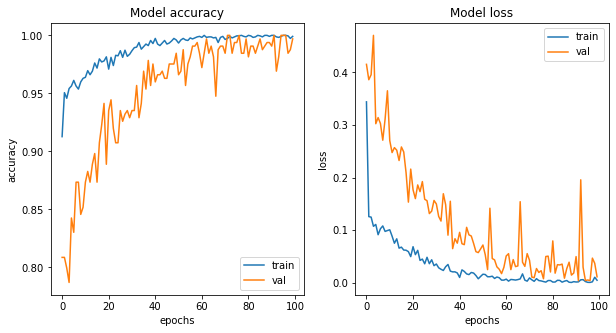

In [ ]:
# Interpreting the Metrics
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss' ]):
    ax[i].plot(history0.history[met])
    ax[i].plot(history0.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
plt.savefig("Model0-Results.png")

In [ ]:
%%time
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results0 = model0.evaluate(test)
print("test loss, test acc:", results0)

Evaluate on test data
81/81 [==============================] - 0s 5ms/step - loss: 0.0375 - accuracy: 0.9907
test loss, test acc: [0.03748706728219986, 0.9907407164573669]
Wall time: 451 ms


# BiLsTM

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the model architecture
model2 = models.Sequential([
    # Since the input includes a singleton dimension, you can use a Lambda layer to remove it
    layers.Lambda(lambda x: tf.squeeze(x, axis=-1), input_shape=(7, 528, 1)),
    # First BiLSTM layer, return sequences to pass to another LSTM layer
    layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
    # Second BiLSTM layer, no need to return sequences as this is the final LSTM layer
    layers.Bidirectional(layers.LSTM(32)),
    # Dense layer for interpretation
    layers.Dense(64, activation='relu'),
    # Dropout for regularization
    layers.Dropout(0.5),
    # Output layer
    layers.Dense(1, activation='sigmoid')
])
 

In [ ]:
# Create an optimizer with the learning rate schedule
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model2.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 7, 528)            0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 7, 128)            303616    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 349,057
Trainable params: 349,057
Non-trainable params: 0
________________________________________________

In [ ]:
history2 = model2.fit(train_data, epochs=100, verbose=1, validation_data=val,batch_size=16)

Epoch 1/100
810/810 [==============================] - 13s 12ms/step - loss: 0.3783 - accuracy: 0.8167 - val_loss: 0.6175 - val_accuracy: 0.7207
Epoch 2/100
810/810 [==============================] - 9s 11ms/step - loss: 0.3413 - accuracy: 0.8435 - val_loss: 0.5638 - val_accuracy: 0.7130
Epoch 3/100
810/810 [==============================] - 9s 11ms/step - loss: 0.3172 - accuracy: 0.8593 - val_loss: 0.5122 - val_accuracy: 0.7531
Epoch 4/100
810/810 [==============================] - 8s 10ms/step - loss: 0.3179 - accuracy: 0.8602 - val_loss: 0.5419 - val_accuracy: 0.7145
Epoch 5/100
810/810 [==============================] - 8s 10ms/step - loss: 0.3068 - accuracy: 0.8633 - val_loss: 0.5097 - val_accuracy: 0.7531
Epoch 6/100
810/810 [==============================] - 8s 10ms/step - loss: 0.2828 - accuracy: 0.8750 - val_loss: 0.5267 - val_accuracy: 0.7284
Epoch 7/100
810/810 [==============================] - 8s 10ms/step - loss: 0.2805 - accuracy: 0.8731 - val_loss: 0.4568 - val_accuracy

In [ ]:
model2.save("Model-combined-Bilstm.h5")
print('Model save to Disk')

Model save to Disk


In [ ]:
df = pd.DataFrame(history2.history) 
#df.to_excel("output.xlsx")
#df.to_csv("output.csv")
df.head(50)

,loss,accuracy,val_loss,val_accuracy
0,0.378270,0.816667,0.617548,0.720679
1,0.341338,0.843518,0.563850,0.712963
2,0.317245,0.859259,0.512233,0.753086
3,0.317924,0.860185,0.541886,0.714506
4,0.306799,0.863272,0.509687,0.753086
5,0.282790,0.875000,0.526720,0.728395
6,0.280451,0.873148,0.456792,0.790123
7,0.265480,0.883951,0.520271,0.726852
8,0.288188,0.871605,0.474372,0.773148
9,0.261175,0.894136,0.444764,0.799383


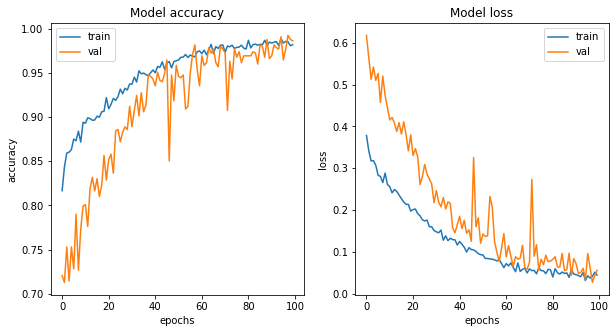

In [ ]:
# Interpreting the Metrics
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss' ]):
    ax[i].plot(history2.history[met])
    ax[i].plot(history2.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
plt.savefig("Model2-Results.png")

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98       164
         1.0       0.98      0.99      0.98       160

    accuracy                           0.98       324
   macro avg       0.98      0.98      0.98       324
weighted avg       0.98      0.98      0.98       324

[[161   3]
 [  2 158]]


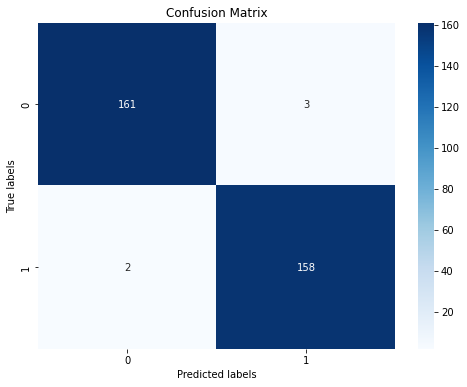

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Step 4: Make predictions and evaluate on the test set
true_labels = []
predicted_labels = []

for samples, labels in test.as_numpy_iterator():
    predictions = model2.predict(samples)
    predicted_classes = (predictions > 0.5).astype(int)  # Adjust threshold as needed
    true_labels.extend(labels)
    predicted_labels.extend(predicted_classes)

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Step 5: Classification report and confusion matrix
print(classification_report(true_labels, predicted_labels))
cm = confusion_matrix(true_labels, predicted_labels)
print(cm)

# Plot the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [ ]:
%%time
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results1 = model2.evaluate(test)
print("test loss, test acc:", results1)

Evaluate on test data
81/81 [==============================] - 0s 6ms/step - loss: 0.0767 - accuracy: 0.9660
test loss, test acc: [0.07669439166784286, 0.9660493731498718]
Wall time: 497 ms


              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98       164
         1.0       0.97      0.99      0.98       160

    accuracy                           0.98       324
   macro avg       0.98      0.98      0.98       324
weighted avg       0.98      0.98      0.98       324

[[159   5]
 [  1 159]]


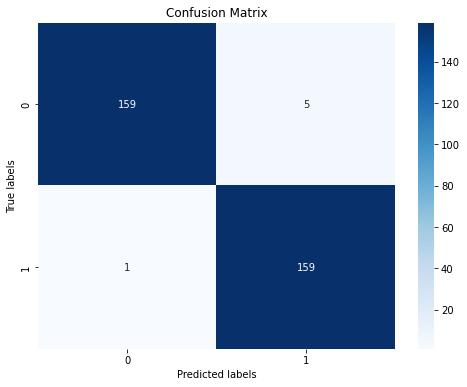

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Step 4: Make predictions and evaluate on the test set
true_labels = []
predicted_labels = []

for samples, labels in test.as_numpy_iterator():
    predictions = model2.predict(samples)
    predicted_classes = (predictions > 0.5).astype(int)  # Adjust threshold as needed
    true_labels.extend(labels)
    predicted_labels.extend(predicted_classes)

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Step 5: Classification report and confusion matrix
print(classification_report(true_labels, predicted_labels))
cm = confusion_matrix(true_labels, predicted_labels)
print(cm)

# Plot the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


# BiRNN

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the model architecture
model3 = models.Sequential([
    # Since the input includes a singleton dimension, you can use a Lambda layer to remove it
    layers.Lambda(lambda x: tf.squeeze(x, axis=-1), input_shape=(7, 528, 1)),
    # First BiLSTM layer, return sequences to pass to another LSTM layer
    layers.Bidirectional(layers.SimpleRNN(64, return_sequences=True)),
    # Second BiLSTM layer, no need to return sequences as this is the final LSTM layer
    layers.Bidirectional(layers.SimpleRNN(32)),
    # Dense layer for interpretation
    layers.Dense(64, activation='relu'),
    # Dropout for regularization
    layers.Dropout(0.5),
    # Output layer
    layers.Dense(1, activation='sigmoid')
])
 

In [ ]:
# Create an optimizer with the learning rate schedule
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model3.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 7, 528)            0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 7, 128)            75904     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 64)                10304     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 90,433
Trainable params: 90,433
Non-trainable params: 0
__________________________________________________

In [ ]:
history3 = model3.fit(train_data, epochs=50, verbose=1, validation_data=val, batch_size=16)

Epoch 1/50
810/810 [==============================] - 26s 30ms/step - loss: 0.3759 - accuracy: 0.8015 - val_loss: 0.6352 - val_accuracy: 0.6836
Epoch 2/50
810/810 [==============================] - 24s 30ms/step - loss: 0.3728 - accuracy: 0.8099 - val_loss: 0.6330 - val_accuracy: 0.6759
Epoch 3/50
810/810 [==============================] - 24s 30ms/step - loss: 0.3444 - accuracy: 0.8417 - val_loss: 0.5764 - val_accuracy: 0.6975
Epoch 4/50
810/810 [==============================] - 23s 28ms/step - loss: 0.3288 - accuracy: 0.8488 - val_loss: 0.5556 - val_accuracy: 0.7176
Epoch 5/50
810/810 [==============================] - 24s 29ms/step - loss: 0.3201 - accuracy: 0.8528 - val_loss: 0.4999 - val_accuracy: 0.7654
Epoch 6/50
810/810 [==============================] - 25s 31ms/step - loss: 0.3033 - accuracy: 0.8691 - val_loss: 0.4944 - val_accuracy: 0.7623
Epoch 7/50
810/810 [==============================] - 23s 29ms/step - loss: 0.2941 - accuracy: 0.8707 - val_loss: 0.4799 - val_accuracy:

In [ ]:
model3.save("Model-combined-BiRNN.h5")
print('Model save to Disk')

Epoch 1/20


NotFoundError: Graph execution error:

Detected at node 'sequential_6/conv2d_4/Relu' defined at (most recent call last):
    File "e:\CondaEnv\gpu-env\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "e:\CondaEnv\gpu-env\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "e:\CondaEnv\gpu-env\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "e:\CondaEnv\gpu-env\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "e:\CondaEnv\gpu-env\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "e:\CondaEnv\gpu-env\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "e:\CondaEnv\gpu-env\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "e:\CondaEnv\gpu-env\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "e:\CondaEnv\gpu-env\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "e:\CondaEnv\gpu-env\lib\site-packages\ipykernel\kernelbase.py", line 542, in dispatch_queue
      await self.process_one()
    File "e:\CondaEnv\gpu-env\lib\site-packages\ipykernel\kernelbase.py", line 531, in process_one
      await dispatch(*args)
    File "e:\CondaEnv\gpu-env\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "e:\CondaEnv\gpu-env\lib\site-packages\ipykernel\ipkernel.py", line 359, in execute_request
      await super().execute_request(stream, ident, parent)
    File "e:\CondaEnv\gpu-env\lib\site-packages\ipykernel\kernelbase.py", line 775, in execute_request
      reply_content = await reply_content
    File "e:\CondaEnv\gpu-env\lib\site-packages\ipykernel\ipkernel.py", line 446, in do_execute
      res = shell.run_cell(
    File "e:\CondaEnv\gpu-env\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "e:\CondaEnv\gpu-env\lib\site-packages\IPython\core\interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "e:\CondaEnv\gpu-env\lib\site-packages\IPython\core\interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "e:\CondaEnv\gpu-env\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "e:\CondaEnv\gpu-env\lib\site-packages\IPython\core\interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "e:\CondaEnv\gpu-env\lib\site-packages\IPython\core\interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "e:\CondaEnv\gpu-env\lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\mdsab\AppData\Local\Temp\ipykernel_11684\1313538127.py", line 3, in <module>
      history2 = model2.fit(train,
    File "e:\CondaEnv\gpu-env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "e:\CondaEnv\gpu-env\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "e:\CondaEnv\gpu-env\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "e:\CondaEnv\gpu-env\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "e:\CondaEnv\gpu-env\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "e:\CondaEnv\gpu-env\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "e:\CondaEnv\gpu-env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "e:\CondaEnv\gpu-env\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "e:\CondaEnv\gpu-env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "e:\CondaEnv\gpu-env\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "e:\CondaEnv\gpu-env\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "e:\CondaEnv\gpu-env\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "e:\CondaEnv\gpu-env\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "e:\CondaEnv\gpu-env\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "e:\CondaEnv\gpu-env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "e:\CondaEnv\gpu-env\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "e:\CondaEnv\gpu-env\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "e:\CondaEnv\gpu-env\lib\site-packages\keras\layers\convolutional\base_conv.py", line 314, in call
      return self.activation(outputs)
    File "e:\CondaEnv\gpu-env\lib\site-packages\keras\activations.py", line 317, in relu
      return backend.relu(
    File "e:\CondaEnv\gpu-env\lib\site-packages\keras\backend.py", line 5366, in relu
      x = tf.nn.relu(x)
Node: 'sequential_6/conv2d_4/Relu'
No algorithm worked!  Error messages:
  Profiling failure on CUDNN engine 1#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 17063040 bytes.
  Profiling failure on CUDNN engine 1: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 17063040 bytes.
  Profiling failure on CUDNN engine 0#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine 0: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine 2#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine 2: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine 6#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16813568 bytes.
  Profiling failure on CUDNN engine 6: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16813568 bytes.
  Profiling failure on CUDNN engine 5#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 19318784 bytes.
  Profiling failure on CUDNN engine 5: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 19318784 bytes.
  Profiling failure on CUDNN engine 7#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 464868352 bytes.
  Profiling failure on CUDNN engine 7: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 464868352 bytes.
	 [[{{node sequential_6/conv2d_4/Relu}}]] [Op:__inference_train_function_190597]

In [ ]:
df = pd.DataFrame(history3.history) 
#df.to_excel("output.xlsx")
#df.to_csv("output.csv")
df.head(50)

,loss,accuracy,val_loss,val_accuracy
0,0.375876,0.801543,0.635170,0.683642
1,0.372846,0.809877,0.633021,0.675926
2,0.344396,0.841667,0.576398,0.697531
3,0.328819,0.848765,0.555616,0.717593
4,0.320102,0.852778,0.499870,0.765432
5,0.303314,0.869136,0.494383,0.762346
6,0.294085,0.870679,0.479925,0.750000
7,0.298331,0.866667,0.468758,0.766975
8,0.283909,0.868827,0.478598,0.768519
9,0.276581,0.879630,0.464711,0.787037


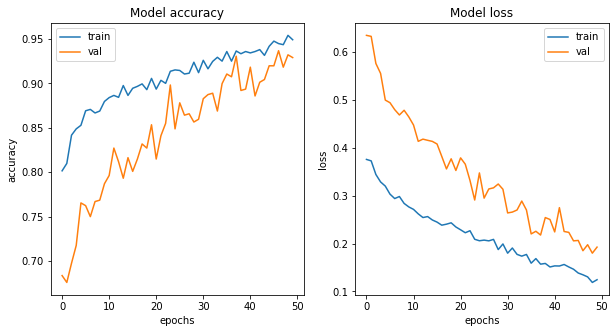

In [ ]:
# Interpreting the Metrics
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss' ]):
    ax[i].plot(history3.history[met])
    ax[i].plot(history3.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
plt.savefig("Model3-Results.png")

In [ ]:
%%time
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results0 = model3.evaluate(test)
print("test loss, test acc:", results0)

Evaluate on test data
81/81 [==============================] - 1s 7ms/step - loss: 0.1410 - accuracy: 0.9537
test loss, test acc: [0.14101670682430267, 0.9537037014961243]
Wall time: 622 ms


              precision    recall  f1-score   support

         0.0       0.90      0.95      0.93       151
         1.0       0.96      0.91      0.93       173

    accuracy                           0.93       324
   macro avg       0.93      0.93      0.93       324
weighted avg       0.93      0.93      0.93       324

[[144   7]
 [ 16 157]]


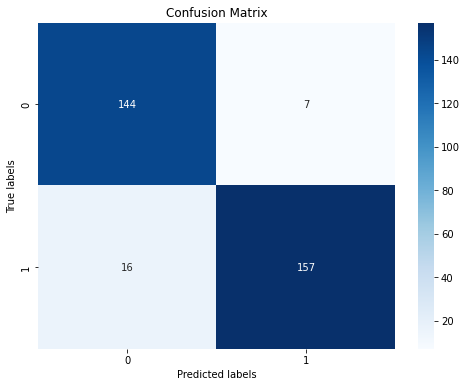

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Step 4: Make predictions and evaluate on the test set
true_labels = []
predicted_labels = []

for samples, labels in test.as_numpy_iterator():
    predictions = model3.predict(samples)
    predicted_classes = (predictions > 0.5).astype(int)  # Adjust threshold as needed
    true_labels.extend(labels)
    predicted_labels.extend(predicted_classes)

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Step 5: Classification report and confusion matrix
print(classification_report(true_labels, predicted_labels))
cm = confusion_matrix(true_labels, predicted_labels)
print(cm)

# Plot the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

# SVM

In [ ]:
import numpy as np

def preprocess_dataset(dataset):
    # Flatten each sample and collect them
    all_samples = []
    all_labels = []

    for samples, labels in dataset.as_numpy_iterator():
        # Flatten from (4, 7, 469, 1) to (4, 7*469)
        samples_flattened = samples.reshape(samples.shape[0], -1)
        all_samples.append(samples_flattened)
        all_labels.append(labels)

    # Convert lists to numpy arrays
    all_samples = np.vstack(all_samples)  # Stack arrays vertically
    all_labels = np.concatenate(all_labels)
    
    return all_samples, all_labels

# Prepare the full dataset into features and labels
X, y = preprocess_dataset(train_data)  # Assuming train_data contains both train and test



In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=48)


In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import svm

# Create an SVM model with a pipeline that includes scaling
model_svm = make_pipeline(
    StandardScaler(),
    svm.SVC(kernel='rbf', random_state=84)
)

# Train the model
model_svm.fit(X_train, y_train)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(random_state=84))])

In [ ]:
accuracy = model_svm.score(X_test, y_test)
print(f'Test accuracy: {accuracy}')


Test accuracy: 0.9022633744855967


Accuracy: 0.9022633744855967
Precision: 0.9208282582216809
Recall: 0.9618320610687023
F1 Score: 0.940883634100809


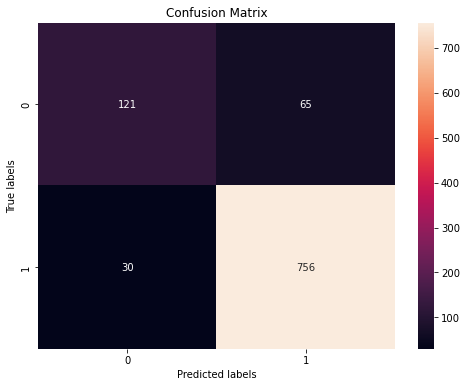

In [ ]:
from sklearn import svm, metrics
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Predict with the model
y_pred = model_svm.predict(X_test)

# Calculate metrics
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)

# Print the metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Plotting the confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()